<a href="https://colab.research.google.com/github/naidu-03/Dementia_detection/blob/main/Dementia__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import packages
!pip install geneticalgorithm
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15079 sha256=dc2a0a735a3f0fce450ac9b21e646cca89f9215353653c31e0ef85e47e8d9f5d
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
# 1. data selection
dataframe = pd.read_csv("/content/oasis_longitudinal.csv")

In [ ]:
# 2. pre processing
# checking missing values
median = dataframe['MMSE'].mean()
dataframe['MMSE'].fillna(median, inplace=True)
median = dataframe['SES'].mean()
dataframe['SES'].fillna(median, inplace=True)

<ipython-input-4-74a705c9b896>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = dataframe.corr()


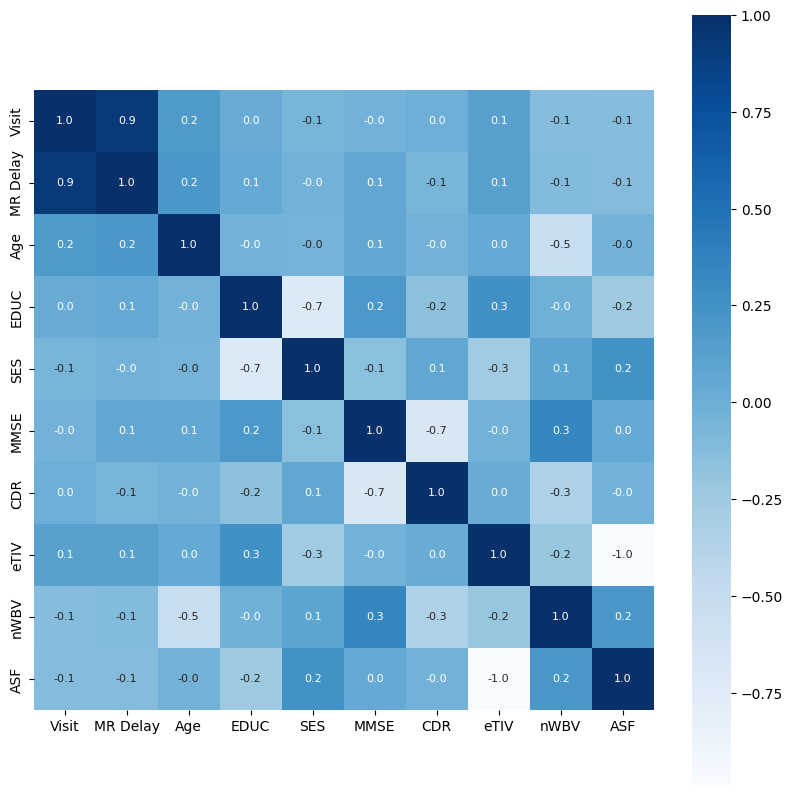

In [ ]:
# visualization
dataframe['Group'] = dataframe['Group'].replace(['Converted'], ['Demented'])
# sns.countplot(x='Group', data=dataframe)

categorical_columns = ['M/F', 'Hand','Group']
df_encoded = pd.get_dummies(dataframe, columns=categorical_columns)
# sns.countplot(x='Group', data=dataframe)
correlation = dataframe.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt = '.1f', annot = True, annot_kws={'size':8}, cmap = 'Blues')
plt.show()


In [ ]:
# 3. data splitting
feature_col_names = ["EDUC", "ASF", "eTIV", "MMSE","nWBV","CDR"]
predicted_class_names = ['Group_Demented']
print(dataframe)
print(df_encoded)
X = df_encoded[feature_col_names].values
y = df_encoded[predicted_class_names].values

# PCA
pca = PCA(n_components=5)
X = pca.fit_transform(X)

# spliting the x and y into test and train
test_size = 0.40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=2)

y_train = y_train.reshape(int(dataframe.shape[0]*(1-test_size)))


    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
0    OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87   
1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
4    OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80   
..         ...            ...          ...    ...       ...  ..  ...  ...   
368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   

     EDUC       SES  MMSE  CDR  eTIV   nWBV    ASF  
0      14  2.000000  2

 The best solution found:
 [24. 20.  5.  5.]

 Objective function:
 -0.9666666666666667


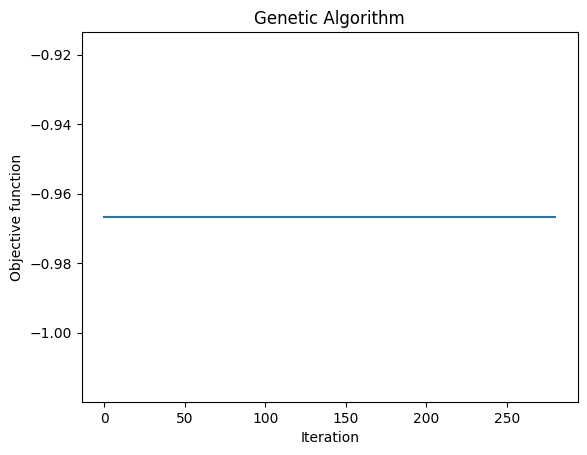

In [ ]:
# 4. Genetic algorithm optimization
def fitness_function(X):
    clf = DecisionTreeClassifier(max_depth=int(X[0]),
                                 min_samples_split=int(X[1]),
                                 min_samples_leaf=int(X[2]),
                                 max_features=int(X[3]))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    return -1*((cm[0][0]+cm[1][1])/len(y_test))

varbound = np.array([[1,30]]*1+[[2,20]]*1+[[1,20]]*1+[[1,5]]*1)
model = ga(function=fitness_function, dimension=4, variable_type='int', variable_boundaries=varbound)
model.run()

In [ ]:
# 5. Model fitting
DT = DecisionTreeClassifier(max_depth=int(model.best_variable[0]),
                            min_samples_split=int(model.best_variable[1]),
                            min_samples_leaf=int(model.best_variable[2]),
                            max_features=int(model.best_variable[3]))

DT.fit(X_train, y_train)

# 6. Prediction
pred = DT.predict(X_test)

---------------------------------------
Accuracy:  96.66666666666667 %
Precision:  97.46835443037975 %
Recall:  96.25 %
Sensitivity:  96.25 %
Specificity:  97.14285714285714 %
F1_score:  96.85534591194968 %


[96.66666666666667,
 97.46835443037975,
 96.25,
 96.25,
 97.14285714285714,
 96.85534591194968]

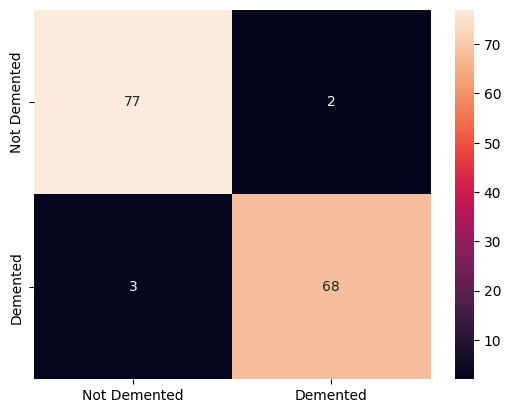

In [ ]:
# 7. Performance evaluation
def get_accuracy(info):
    cm1=confusion_matrix(y_test, info)
    TP = cm1[0][0] #true positive
    FP = cm1[0][1]
    FN = cm1[1][0]
    TN = cm1[1][1]
    sns.heatmap(cm1, annot=True, fmt='0.0f', xticklabels=['Not Demented','Demented'], yticklabels=['Not Demented','Demented'])
    Total=TP+TN+FP+FN
    accuracy=((TP+TN)/Total)*100
    precision=TP/(TP+FP)*100
    recall=TP/(TP+FN)*100
    sensitivity=TP/(TP+FN)*100
    specificity = (TN / (TN+FP))*100
    F1_score = (2 * precision * sensitivity) / (precision + sensitivity)

    print("---------------------------------------")
    print("Accuracy: ",accuracy,'%')
    print("Precision: ",precision,'%')
    print("Recall: ",recall,'%')
    print("Sensitivity: ",sensitivity,'%')
    print("Specificity: ",specificity,'%')
    print("F1_score: ",F1_score,'%')

    return [accuracy, precision,recall, sensitivity, specificity, F1_score]
info =pred
get_accuracy(info)

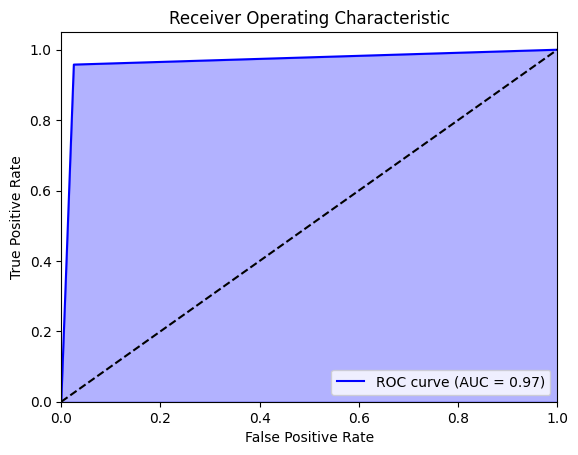

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test,info)
auc = roc_auc_score(y_test,info)
#plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot(fpr, tpr, color='b',label='ROC curve (AUC = %0.2f)' % auc)
plt.fill_between(fpr, tpr, color='b', alpha=0.3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:

import pickle
with open('dementia_detect.pickle','wb') as f:
  pickle.dump(DT,f)

In [ ]:
#"EDUC", "ASF", "eTIV", "MMSE","nWBV","CDR"
input_data = [[12, 1.2, 1300, 28, 0.2, 0.5]]
input_data = pca.transform(input_data)
pred = DT.predict(input_data)
print(pred)

[1]


In [ ]:
#"EDUC", "ASF", "eTIV", "MMSE","nWBV","CDR"
input_data = [[14, 0.883, 1987, 27, 0.696, 0]]
input_data = pca.transform(input_data)
pred = DT.predict(input_data)
print(pred)

[0]
